#### Concept of attention in Transformers
Transformers have self-attention mechanism which is the ability to attend to & relate multiple positions in a single sequence  & compute a representation of that sequence.Transformers have stacked self-attention layers.

Advantages - 

1. It makes no assumptions about spatial/temporal relationships among words in a sequence.
2. Layer outputs can be computed in parallel instead of series like RNN/CNN.
3. Distant words in a sequence can be related and affect each other's output without passing through RNN steps or convolutional layers.
4. Allows capturing long term dependencies among words in an input sequence which is a challenge in sequence tasks.

Limitations - 
1. Since it treats input eg.words in input sequence as independent, external means such as positional encodings to capture relative positions of words in sequence / order is required to be incorporated in the output embeddings.
2. For a time series, the output is calculated from the entire history instead of only the inputs and current hidden state.



In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

### Setting up input pipeline

In [2]:
%time examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteHOV7F6/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteHOV7F6/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteHOV7F6/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.
CPU times: user 15.4 s, sys: 1.37 s, total: 16.8 s
Wall time: 27.9 s


In [3]:
examples

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'validation': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>}

In [4]:
type(examples), type(examples['test'])

(dict, tensorflow.python.data.ops.dataset_ops.PrefetchDataset)

In [5]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)

In [6]:
train_examples, validation_examples = examples['train'], examples['validation']

Create custom subwords tokenizer from training dataset using byte-encodings for out of vocabulary tokens

In [7]:
for lang1, lang2 in train_examples:
  print(lang1)
  print(lang2)
  break

tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)
tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)


In [8]:
%time en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

%time pt_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

CPU times: user 1min 16s, sys: 2.76 s, total: 1min 19s
Wall time: 1min 8s
CPU times: user 1min 40s, sys: 2.92 s, total: 1min 43s
Wall time: 1min 33s


In [9]:
len(en_tokenizer.subwords)

7830

In [10]:
en_tokenizer.vocab_size

8087

Add start & end token to the source and target language data

In [11]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40

In [12]:
def encode(lang1, lang2):
  lang1 = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(lang1.numpy()) + [pt_tokenizer.vocab_size+1]
  lang2 = [en_tokenizer.vocab_size] + en_tokenizer.encode(lang2.numpy()) + [en_tokenizer.vocab_size+1]
  return lang1, lang2

# Use py_function to wrap the above function within and apply it over all elements in the dataset

def tf_encode(pt, en):
  # Wrapping the encode python function into a TensorFlow op
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64], 'encode')      # function to be wrapped, 
  result_pt.set_shape([None])         # Perform shape assertion. Passing none indicates the size of dataset can be any value i.e any value of batch size
  result_en.set_shape([None])
  return result_pt, result_en

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= MAX_LENGTH,
                        tf.size(y) <= MAX_LENGTH)


In [13]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

In [14]:
i = 0
for lang1, lang2 in train_dataset:
  print(lang1)
  print(lang2)
  i += 1
  if i > 3:
    break

tf.Tensor(
[8214    6   40 4092   57    3 1687    1 6155   12    3  461 6770   19
 5227 1088   97    1    5    8    3 4213 3408 7256 1670    2 8215], shape=(27,), dtype=int64)
tf.Tensor(
[8087    4   59   15 1792 6561 3060 7952    1   15  103  134  378    3
   47 6122    6 5311    1   91   13 1849  559 1609  894    2 8088], shape=(27,), dtype=int64)
tf.Tensor([8214   25    6   16  138 7800 2004 2445 8073   29 8215], shape=(11,), dtype=int64)
tf.Tensor([8087   23   29   44   17   72 4332   33 8088], shape=(9,), dtype=int64)
tf.Tensor([8214   25   66   13  342    3 5278 7990    4   38 3625 8072    2 8215], shape=(14,), dtype=int64)
tf.Tensor([8087   23   25   98 7941 7870   26  916   21 4287    2 8088], shape=(12,), dtype=int64)
tf.Tensor(
[8214    6   54 3906 2682  156 2646 7990    8    3  496  139  216  354
    1   21 1712  243 4206    1  375  130   75 1960    2 8215], shape=(26,), dtype=int64)
tf.Tensor(
[8087    4   16 5443 3367 2054   13  154 7936    1   37   45 2734 5915
 1510    1

Cache the dataset in memory to get speedup while reading from it

In [15]:
train_dataset.cache()
train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)        # Use padded batch when batching a dataset with variable shape

# Fetch the input data before it is requested for preprocessing. Decouples fetching & consumption
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)          

In [16]:
type(train_dataset.shuffle(BUFFER_SIZE))

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [17]:
val_dataset = validation_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [18]:
num_positions = 50
depth = 512
min_rate = 1/10000

#### Positional encoding

This encoding is a vector of sines and cosines at each position, where each sine-cosine pair rotates at a different frequency.
The angle rates range from 1 [rads/step] to min_rate [rads/step] over the vector depth.
The resulting exponent goes from 0 to 1, causing the angle_rates to drop exponentially from 1 to min_rate.
Broadcasting a multiply over angle rates and positions gives a map of the position encoding angles as a function of depth.
Raw angles are not a good model input (they're either unbounded, or discontinuous). So take the sine and cosine:

In [19]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sine to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cosine to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


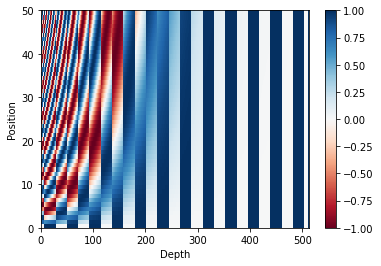

In [20]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Masking

1. Masking paddings-

Return a 1 wherever an input is 0 , due ensure the model doesn't treat padding as input.

2. Look ahead masking -

Mask future tokens in a sequence, to specify which entries not to be used.
For eg. in a language model, only first 2 words should be used to predict the 3rd word, and first 3 words to predict the 4th word and so on.

In [21]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]      # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask                                  # (seq_len, seq_len)

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

There are 3 types of Attention -
1. Encoder/Decoder
2. Causal 
3. Bi-directional

In causal attention, keys, queries, values come from the same sentence & queries search among the past words only. This is where look-ahead masking is used to mask positions to make it causal.

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.

  Args:
  q: query shape = (..., seq_len_q, depth)
  k: key shape = (..., seq_len_k, depth)
  v: value shape = (..., seq_len_v, depth_v)
  mask: float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None

  Returns:
  output, attention_weights
  """
  matmul_qk = tf.matmul(q,k, transpose_b=True)         # (..., seq_len_q, seq_len_k)
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9) 

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)     # (..., seq_len_q, seq_len_k)
  output = tf.matmul(attention_weights, v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [23]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [24]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [25]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [26]:
# whichever vector/word in key has larger values, will gain more weightage in attention

temp_k = tf.constant([[2,1,3], [4,5,6]] , dtype=tf.float32)       # (seq_len, dim)
temp_q = tf.constant([[2.5,1.5,3.5]], tf.float32)                 # q vector is closer to 1st word in sequence in temp_k
print(temp_q)
print_out(temp_q, temp_k, temp_k)

tf.Tensor([[2.5 1.5 3.5]], shape=(1, 3), dtype=float32)
Attention weights are:
tf.Tensor([[0.00000407 0.99999595]], shape=(1, 2), dtype=float32)
Output is:
tf.Tensor([[3.999992 4.999984 5.999988]], shape=(1, 3), dtype=float32)


In [ ]:
# Here, 2 words in the sequence are close to each other.
temp_k = tf.constant([[2.5,1.5,3.5], [2.0,1.0,3.0]] , dtype=tf.float32)  # (seq_len, dim)
temp_q = tf.constant([[2.5,1.5,3.5]], tf.float32)                        # q vector is closer to 1st word in sequence in temp_k

print(temp_q)
print_out(temp_q, temp_k, temp_k)

tf.Tensor([[2.5 1.5 3.5]], shape=(1, 3), dtype=float32)
matmul q k [[20.75 17.  ]]
scaled_attention_logits [[11.980019  9.814955]]
Attention weights are:
tf.Tensor([[0.897068   0.10293192]], shape=(1, 2), dtype=float32)
Output is:
tf.Tensor([[2.448534  1.448534  3.4485338]], shape=(1, 3), dtype=float32)


<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The scaled_dot_product_attention defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

After the split, each head's reduced dimensionality reduces from d_model to d_model / num_heads. Thus, each head 

In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, num_heads, d_model):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % num_heads == 0

    self.depth = d_model // num_heads

    self.w_q = tf.keras.layers.Dense(d_model)
    self.w_k = tf.keras.layers.Dense(d_model)
    self.w_v = tf.keras.layers.Dense(d_model)
    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self,x,batch_size,):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0,2,1,3])

  def call(self, v,k,q,mask):
    batch_size = tf.shape(q)[0]

    q = self.w_q(q)                  # (batch_size, seq_len_q, d_model)
    k = self.w_k(k)                  # (batch_size, seq_len_k, d_model) 
    v = self.w_v(v)                  # (batch_size, seq_len_v, d_model)

    q = self.split_heads(q, batch_size)     # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)     # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)     # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q,k,v,mask)         
 
    scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])           # shape (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))       # shape (batch_size, seq_len_q, d_model)       
    output = self.dense(concat_attention)

    return output, attention_weights

Since multihead attention involves multiple heads, each working on reduced dimension of vector. This means the scaled dot product will be involved for each word in a sequence of length seq_len_q or seq_len_k or seq_len_v with each word represented by reduced dimensions and will be worked upon by 8 heads for each word / location in the sequence.

In the below example, at each location in the sequence, y, the MultiHeadAttention runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [38]:
tmp_mha = MultiHeadAttention(num_heads=8, d_model=512)
y = tf.random.uniform((1,60,512))         # (batch_size, encoder_sequence, d_model)
output, attn_wts = tmp_mha(v=y, q=y, k=y,mask=None)

In [39]:
output.shape, attn_wts.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [40]:
def point_wise_feed_forward_network(pff, d_model):
  return tf.keras.Sequential([
          tf.keras.layers.Dense(pff, activation='relu'),            # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)                            # (batch_size, seq_len, d_model)
  ])

In [41]:
# Testing Point wise feed forward network

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 2048])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head self-attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [42]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, num_heads, d_model, dff, rate=0.1):
    super(EncoderLayer, self).__init__()
    self.mha = MultiHeadAttention(num_heads, d_model)
    self.pff = point_wise_feed_forward_network(dff,d_model)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self,x, training, mask):
    attn_output, _ = self.mha(x,x,x,mask)                       # (batch_size, seq_len_q, d_model)
    attn_output = self.dropout1(attn_output, training)          
    output1 = self.layernorm1(x + attn_output)                  # (batch_size, seq_len_q, d_model)

    ff_output = self.pff(output1)                               # (batch_size, seq_len_q, d_model)
    ff_output = self.dropout2(ff_output)
    output2 = self.layernorm2(x + ff_output)                    # (batch_size, seq_len_q, d_model)

    return output2

In [43]:
sample_encoder_layer = EncoderLayer(8, 512, 2048)

encoder_layer_output = sample_encoder_layer(tf.random.uniform((64,43,512)), False, None)
encoder_layer_output.shape

TensorShape([64, 43, 512])

### Decoder layer

Decoder layer has following sublayers - 

1. Masked multi-head self-attention layer (with look-ahead and padding mask)

2. Multi-head attention layer (with padded mask) over the output of encoder 

This layer receives key and value vectors from encoder's output from input sequence and query vector from output of masked multi-head attention sublayer from target sequence.

3. Point-wise feed forward layer

Each sublayer has a residual connection around it followed by a Layer Normalization. The output of each layer is LayerNormalization(x + Sublayer(x)). The normalization is done of last axis(d_model).

There are N decoder layers.

Since, Q receives input from decoder's first attention block and K is obtained from encoder's output, the attention weights obtained from attending to Q & V represent the importance given to decoder's input based on the encoder's output. In other words, the feed forward network predicts the next words based on encoder's output and self-attending to its own output.


In [44]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, num_heads, d_model, dff, rate=0.1):
    super(DecoderLayer, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    self.masked_mha = MultiHeadAttention(num_heads, d_model)        # Sublayer 1 : for target sequence with look ahead and padding mask 
    self.mha = MultiHeadAttention(num_heads, d_model)               # Sublayer 2: for encoder's output, and previous layer's attention output
    self.ffn = point_wise_feed_forward_network(dff, d_model)        # Sublayer 3

    # 1 layernormalization for each sub layer
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # for masked MHA
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # for MHA
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # for Feed forward nk

    # 1 dropout setting for each sub layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self,x ,enc_output, training, lookahead_mask, padding_mask  ):
    """
    x - query received from decoder from target sequence
    enc_output shape = (batch_size, input_seq_len, d_model)
    """
    attn1, attn_wts_block1 = self.masked_mha(x, x, x, lookahead_mask)              # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(x + attn1)

    attn2, attn_wts_block2 = self.mha(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(out1 + attn2)                                           # (batch_size, target_seq_len, d_model)

    ff_outout = self.ffn(out2)          # (batch_size, target_seq_len, d_model)
    ff_output = self.dropout3(ff_outout, training=training)
    out3 = self.layernorm3(out2 + ff_output)

    return out3, attn_wts_block1, attn_wts_block2

In [45]:
sample_decoder_layer = DecoderLayer(8, 512, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64, 50, 512)), encoder_layer_output, \
    False, None, None)

sample_decoder_layer_output.shape          # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

Encoder has following layers

1. Embedding layer to convert token IDs in input sequence to dense vector 
embeddings

2. Position encoding to capture token positions in the input sequence and add it to word embeddings obtained from previous layer

2. N Encoder layers
The output of the position encoding summed with embeddings is input to the Encoder layers and output of Nth Encoder layer is input to the decoder

In [46]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_heads, num_layers, d_model,dff, vocab_size, max_position_encoding_len, rate=0.1 ):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.embedding_layer = tf.keras.layers.Embedding(vocab_size, d_model)
    self.position_encoding = positional_encoding(max_position_encoding_len, d_model)
    self.dropout = tf.keras.layers.Dropout(rate)
    self.encoding_layers = [EncoderLayer(num_heads, d_model, dff, rate) for _ in range(num_layers)]

  def call(self, x, training, padding_mask):
    seq_len = tf.shape(x)[1]
    x = self.embedding_layer(x)
    x *= tf.sqrt(tf.cast(self.d_model, dtype=tf.float32))
    x += self.position_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for enc_layer in self.encoding_layers:
      x = enc_layer(x, training, padding_mask)

    return x     # (batch_size, input_seq_len, d_model)

In [47]:
# Testing Encoder
sample_encoder = Encoder(num_heads=8, num_layers=2, d_model=512, dff=2048, vocab_size=8500,
                         max_position_encoding_len=10000 )

In [48]:
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input, training=False, padding_mask=None)
sample_encoder_output.shape

TensorShape([64, 62, 512])

#### Decoder
The Decoder consists of:

1. Output Embedding
2. Positional Encoding
3. N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [49]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_heads, d_model, dff, maximum_position_encoding, num_layers, target_vocab_size, rate=0.1):
    super(Decoder, self).__init__()
    
    self.d_model = d_model
    self.embedding_layer = tf.keras.layers.Embedding(target_vocab_size, d_model)                     # output embeddings
    self.position_encoding = positional_encoding(maximum_position_encoding, d_model)
    self.dropout = tf.keras.layers.Dropout(rate)
    self.decoding_layers = [DecoderLayer(num_heads, d_model, dff, rate) for _ in range(num_layers)]

  def call(self, x, encoder_output, training, padding_mask, lookahead_mask):
    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding_layer(x)                             # (batch_size, target_seq_len, d_model)
    x *= tf.sqrt(tf.cast(self.d_model, dtype=tf.float32))
    x += self.position_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i,decoding_layer in enumerate(self.decoding_layers):
        x, attn_wts_blk1, attn_wts_blk2 = decoding_layer(x, encoder_output, False, None, None)
      
        attention_weights['decoder_layer{}_block1'.format(i+1)] = attn_wts_blk1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = attn_wts_blk2

    return x, attention_weights                  # x.shape = (batch_size, target_seq_len, d_model)


In [50]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              encoder_output=sample_encoder_output, 
                              training=False,
                              lookahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

Thus we used 3 types of attention in transformers -

1. **Encoder-decoder attention** layers which involves query from output of previous decoder layer and key , values come from the output of encoder. In this every position in the decoder output can attend to all positions in the encoder output's sequence. 

2. **Self attention layers in encoder** where the query, key abnd value vectors come from the same place, here, from the previous encoder layer. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3. **Self attention layers in decoder** where the query, key and value vectors come from the previous layer in the decoder upto and including that position. Here, look ahead masking is also included to prevent positions from attending to subsequent positions.

### Creating Transformer
Transformer consists of encoder, decoder & a final linear layer. The output of the decoder is fed to the final layer whose output is returned as final output.

In [52]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_heads, num_layers, d_model, dff, input_vocab_size, pe_input, rate)
    self.decoder = Decoder(num_heads, d_model, dff, pe_target, num_layers, target_vocab_size, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, look_ahead_mask, enc_padding_mask, dec_padding_mask):
    enc_output = self.encoder(inp, training=training, padding_mask=enc_padding_mask)          # (batch_size, inp_seq_len, d_model)
    decoder_output, attention_weights = self.decoder(tar, enc_output, training, dec_padding_mask, look_ahead_mask)        # (batch_size, target_seq_len, d_model)
    output = self.final_layer(decoder_output)                                    # (batch_size, target_vocab_size)

    return output, attention_weights


In [53]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

In [54]:
fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

In [57]:
fn_out.shape                      # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

### Set hyperparameters
To keep this example small and relatively fast, the values for num_layers, d_model, and dff have been reduced.

The values used in the base model of transformer were; num_layers=6, d_model = 512, dff = 2048. See the paper for all the other versions of the transformer.

In [58]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2
dropout_rate = 0.1

### Optimizer
Using the Adam optimizer with β1 = 0.9, β2 = 0.98 and $\epsilon $ = 10e−9. The learnining rate is varied over the course of training according to the following formula from [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first warmup_steps training steps,
and decreasing it thereafter proportionally to the inverse square root of the step number. We used
warmup_steps = 4000.


In [59]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [61]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

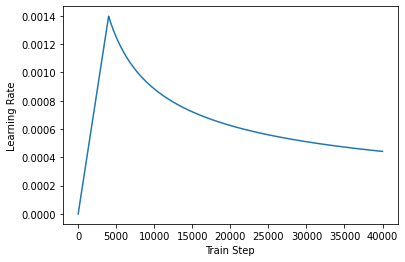

In [64]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Text(0.5, 0, 'Train Step')

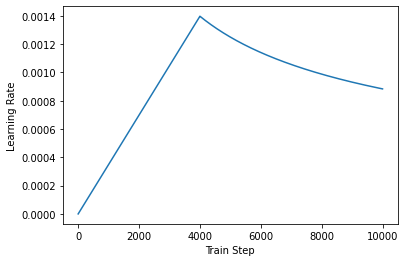

In [66]:
# Notice the learning rate decreasing after 4000 warmup steps 
plt.plot(temp_learning_rate_schedule(tf.range(10000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss and metrics

We will use sparse categorical loss since its'a multi class classification &  the target vectors are integers and not one-hot encoded.

In [83]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [84]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


In [85]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

### Training and checkpointing

In [86]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [87]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [95]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [88]:
EPOCHS = 20

In [89]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

#### References

1. https://www.tensorflow.org/tutorials/text/transformer#top_of_page
2. https://gombru.github.io/2018/05/23/cross_entropy_loss/
3. https://machinelearningmastery.com/cross-entropy-for-machine-learning/
